In [1]:
import glob
import unicodedata
from typing import List, Dict

def unicode_to_ascii(name: str, letters: str) -> str:
    return "".join(
        c for c in unicodedata.normalize("NFKD", name)
        if not unicodedata.combining(c) and c in letters
    )

def get_category_names(filename: str, letters: str, encoding: str = "utf-8") -> List[str]:
    names = open(filename, encoding=encoding).read().strip().split("\n")
    return [unicode_to_ascii(name, letters) for name in names]

def get_data(path: str, letters: str) -> Dict[str, List[str]]:
    files = glob.glob(path)
    category_dict = {}
    for filename in files:
        category = filename.split("\\")[-1].split('.')[0]
        category_dict[category] = get_category_names(filename, letters)
    return category_dict

In [2]:
import string

letters = string.ascii_letters + " .,;'"
n_letters = len(letters)

path = "./data/names/*.txt"

all_filenames = glob.glob(path)

category_dict = get_data(path, letters)
categories = list(category_dict.keys())

In [3]:
n_categories = len(categories)

In [4]:
import torch

In [5]:
def name_to_tensor(name: str) -> torch.Tensor:
    tensor = torch.zeros(len(name), 1, n_letters)
    for i, char in enumerate(name):
        tensor[i, 0, letters.index(char)] = 1
    return tensor

In [6]:
name_to_tensor("Jones")

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [7]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F

class MyRNN(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.i2h = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.i2o = nn.Linear(input_dim + hidden_dim, output_dim)
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_dim)

    def forward(self, x: Tensor, h: Tensor = None) -> Tensor:
        combined = torch.cat((x, h), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return output, hidden

In [8]:
input_dim = n_letters
hidden_dim = 128
output_dim = n_categories

rnn = MyRNN(input_dim, hidden_dim, output_dim)


In [9]:
x = name_to_tensor("Albert")
h = rnn.init_hidden()

output, hidden = rnn(x[0], h)
print(output.size())

torch.Size([1, 18])


In [10]:
def category_from_output(output):
    _, top_i = output.data.topk(1)
    category_i = top_i[0][0]
    return categories[category_i], category_i

print(category_from_output(output))

('Greek', tensor(7))


In [11]:
import random

def random_training_pair():
    category = random.choice(categories)
    name = random.choice(category_dict[category])
    category_tensor = torch.LongTensor([categories.index(category)])
    name_tensor = name_to_tensor(name)
    return category, name, category_tensor, name_tensor

for i in range(10):
    category, name, category_tensor, name_tensor = random_training_pair()
    print('category =', category, '/ name =', name)

category = Arabic / line = Mifsud
category = Irish / line = O'Boyle
category = Polish / line = Rog
category = Greek / line = Samios
category = Vietnamese / line = Giang
category = Polish / line = Niemczyk
category = Korean / line = Youn
category = Dutch / line = Kloeten
category = Russian / line = Yuzhenko
category = Irish / line = Connell


In [12]:
loss_fn = nn.CrossEntropyLoss()
lr = 5e-3
optimizer = torch.optim.SGD(rnn.parameters(), lr=lr, momentum=0.9)

In [13]:
def train(category_tensor, line_tensor):
    hidden = rnn.init_hidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = loss_fn(F.softmax(output, dim=1), category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return output, loss.item()

In [14]:
import time
import math

n_epochs = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 4s) 2.9061 Silveira / Greek ✗ (Portuguese)
10000 10% (0m 9s) 2.8574 O'Brien / Japanese ✗ (Irish)
15000 15% (0m 13s) 2.9541 Simpson / Russian ✗ (Scottish)
20000 20% (0m 18s) 2.9448 Silveira / Japanese ✗ (Portuguese)
25000 25% (0m 22s) 2.9658 Miller / German ✗ (Scottish)
30000 30% (0m 27s) 2.2160 Shim / Korean ✓
35000 35% (0m 31s) 2.9329 Liao / Vietnamese ✗ (Chinese)
40000 40% (0m 36s) 2.1546 Wasem / Arabic ✓
45000 45% (0m 40s) 1.9836 Koo / Korean ✓
50000 50% (0m 45s) 1.9983 Panoulias / Greek ✓
55000 55% (0m 49s) 2.9491 Hill / Chinese ✗ (Scottish)
60000 60% (0m 54s) 2.9792 Crespo / Italian ✗ (Portuguese)
65000 65% (0m 58s) 2.0648 Truong / Vietnamese ✓
70000 70% (1m 3s) 2.8875 O'Hare / French ✗ (Irish)
75000 75% (1m 7s) 2.3704 Moon / Korean ✓
80000 80% (1m 12s) 1.9955 Bello / Italian ✓
85000 85% (1m 16s) 2.9806 Heidl / Irish ✗ (Czech)
90000 90% (1m 21s) 2.0037 Bach / Vietnamese ✓
95000 95% (1m 26s) 1.9844 Benini / Italian ✓
100000 100% (1m 30s) 2.4516 Heel / Dutch ✓


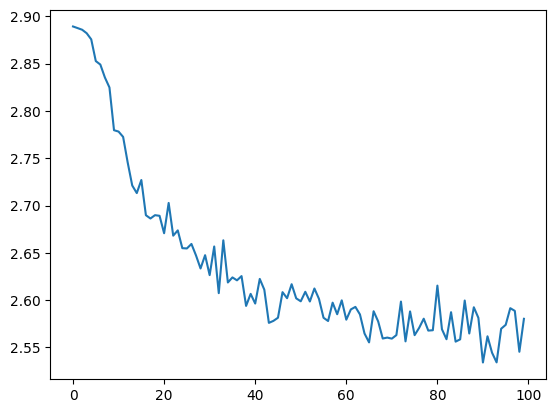

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

C:\Users\User\AppData\Local\Temp\ipykernel_3388\4020151873.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + categories, rotation=90)
C:\Users\User\AppData\Local\Temp\ipykernel_3388\4020151873.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + categories)


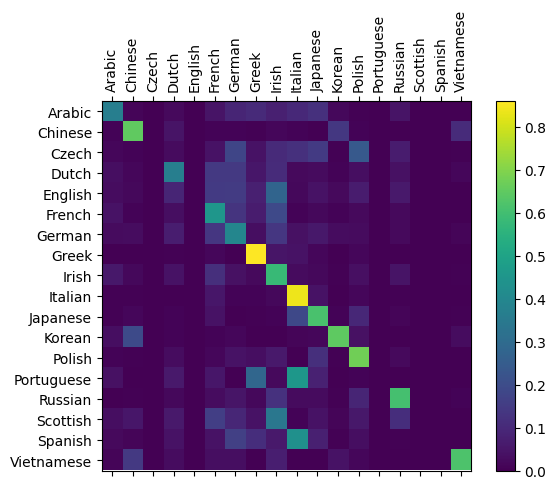

In [16]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + categories, rotation=90)
ax.set_yticklabels([''] + categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [17]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(name_to_tensor(input_line))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, categories[category_index]))
        predictions.append([value, categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(9.03) Russian
(7.23) German
(3.99) Polish

> Jackson
(5.60) Dutch
(4.71) Polish
(4.62) Russian

> Satoshi
(11.32) Polish
(7.45) Italian
(3.78) Greek
